# Coordinate Frame Conventions
A review of coordinate frame conventions in Habitat.

# Installation

In [1]:
# @title Imports { display-mode: "form" }

# [imports]
import os

import git
import magnum as mn
from PIL import Image

import habitat_sim

try:
    # For using jupyter IO components
    import IPython.display

    IS_NOTEBOOK = True

except ImportError:
    IS_NOTEBOOK = False
# [/imports]

In [3]:
os.chdir("/home/junting/repo/habitat-lab")

In [4]:
# @title Setup { display-mode: "form" }

# [setup]
# Choose quiet logging. See src/esp/core/Logging.h
os.environ["HABITAT_SIM_LOG"] = "quiet"

# define path to data directory
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")

# images will be either displayed in the notebook or saved as image files
if not IS_NOTEBOOK:
    output_directory = "examples/tutorials/coordinate_system_tutorial_output/"
    output_path = os.path.join(dir_path, output_directory)
    os.makedirs(output_path, exist_ok=True)

# define some constants and globals the first time we run:
opacity = 1.0
red = mn.Color4(1.0, 0.0, 0.0, opacity)
green = mn.Color4(0.0, 1.0, 0.0, opacity)
blue = mn.Color4(0.0, 0.0, 1.0, opacity)
white = mn.Color4(1.0, 1.0, 1.0, opacity)

origin = mn.Vector3(0.0, 0.0, 0.0)
eye_pos0 = mn.Vector3(2.5, 1.3, 1)
eye_pos1 = mn.Vector3(3.5, 3.0, 4.5)
obj_axes_len = 0.4

if "sim" not in globals():
    global sim
    sim = None
    global sensor_node
    sensor_node = None
    global lr
    lr = None
    global image_counter
    image_counter = 0
# [/setup]

In [5]:
# @title Utilities { display-mode: "form" }


# [utils]
def create_sim_helper(scene_id):
    global sim
    global sensor_node
    global lr

    # clean-up the current simulator instance if it exists
    if sim != None:
        sim.close()

    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.scene_dataset_config_file = os.path.join(
        data_path, "replica_cad/replicaCAD.scene_dataset_config.json"
    )
    sim_cfg.scene_id = scene_id
    sim_cfg.enable_physics = True  # for ReplicaCAD articulated furniture

    agent_cfg = habitat_sim.agent.AgentConfiguration()
    rgb_sensor_spec = habitat_sim.CameraSensorSpec()
    rgb_sensor_spec.uuid = "color_sensor"
    rgb_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    rgb_sensor_spec.resolution = [768, 1024]
    rgb_sensor_spec.position = [0.0, 0.0, 0.0]
    agent_cfg.sensor_specifications = [rgb_sensor_spec]

    cfg = habitat_sim.Configuration(sim_cfg, [agent_cfg])
    sim = habitat_sim.Simulator(cfg)

    # This tutorial doesn't involve agent concepts. We want to directly set
    # camera transforms in world-space (the world's coordinate frame). We set
    # the agent transform to identify and then return the sensor node.
    sim.initialize_agent(0)
    agent_node = sim.get_agent(0).body.object
    agent_node.translation = [0.0, 0.0, 0.0]
    agent_node.rotation = mn.Quaternion()
    sensor_node = sim._sensors["color_sensor"]._sensor_object.object

    lr = sim.get_debug_line_render()
    lr.set_line_width(3)


def show_img(rgb_obs):
    global image_counter

    colors = []
    for row in rgb_obs:
        for rgba in row:
            colors.extend([rgba[0], rgba[1], rgba[2]])

    resolution_x = len(rgb_obs[0])
    resolution_y = len(rgb_obs)

    colors = bytes(colors)
    img = Image.frombytes("RGB", (resolution_x, resolution_y), colors)
    if IS_NOTEBOOK:
        IPython.display.display(img)
    else:
        filepath = f"{output_directory}/{image_counter}.png"
        img.save(filepath)
        print(f"Saved image: {filepath}")
        image_counter += 1


def show_scene(camera_transform):
    sensor_node.transformation = camera_transform
    observations = sim.get_sensor_observations()
    show_img(observations["color_sensor"])


def draw_axes(translation, axis_len=1.0):
    lr = sim.get_debug_line_render()
    # draw axes with x+ = red, y+ = green, z+ = blue
    lr.draw_transformed_line(translation, mn.Vector3(axis_len, 0, 0), red)
    lr.draw_transformed_line(translation, mn.Vector3(0, axis_len, 0), green)
    lr.draw_transformed_line(translation, mn.Vector3(0, 0, axis_len), blue)


def calc_camera_transform(
    eye_translation=mn.Vector3(1, 1, 1), lookat=mn.Vector3(0, 0, 0)
):
    # choose y-up to match Habitat's y-up convention
    camera_up = mn.Vector3(0.0, 1.0, 0.0)
    return mn.Matrix4.look_at(eye_translation, lookat, camera_up)


# [/utils]

# Coordinate frame conventions: y-up and right-handed
Create a sim with an empty scene. Draw the world axes at the origin, with colors x+ = red, y+ = green, z+ = blue. Note conventions: y-up (green vector) and right-handed (https://en.wikipedia.org/wiki/Right-hand_rule).

[11:48:36:569164]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_00.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[11:48:36:569228]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_01.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[11:48:36:569279]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_02.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[11:48:36:569329]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_03.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/ha

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 525.147.05
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


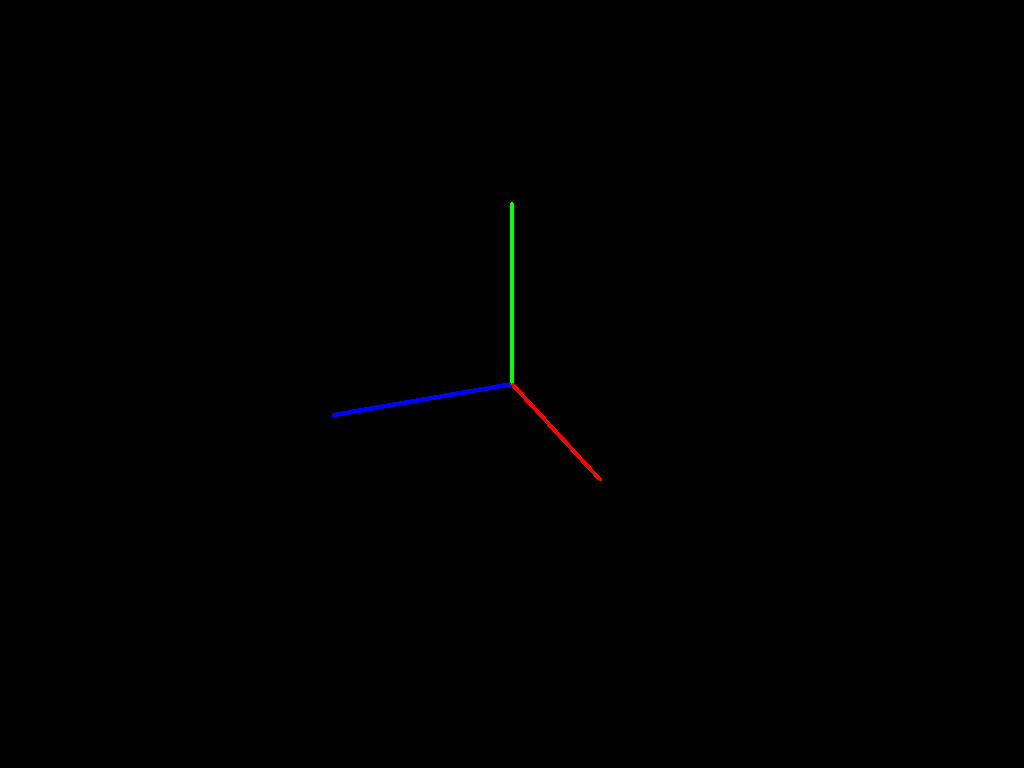

In [7]:
# [empty_scene_coord_frame]
create_sim_helper(scene_id="NONE")
draw_axes(origin)
show_scene(calc_camera_transform(eye_translation=eye_pos0, lookat=origin))
# [/empty_scene_coord_frame]

# Loading a ReplicaCAD scene
Draw the world axes again.

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 525.147.05
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


[11:49:11:780995]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_00.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[11:49:11:781063]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_01.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[11:49:11:781116]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_02.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[11:49:11:781168]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_03.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/ha

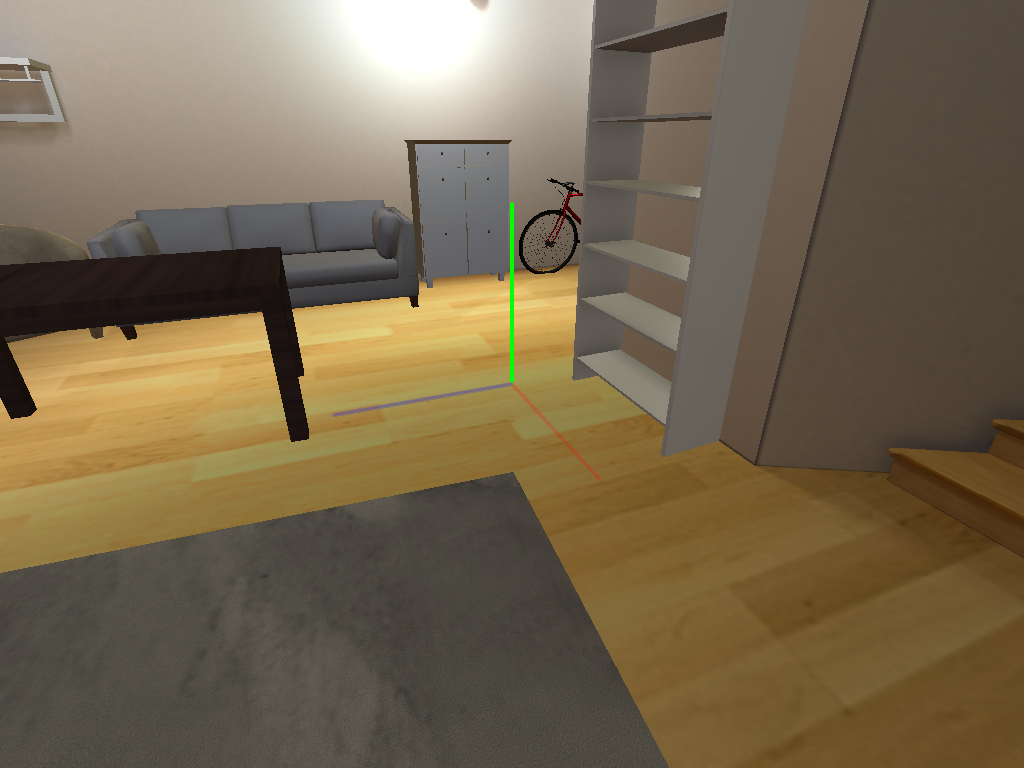

In [8]:
# [replica_cad_scene_coord_frame]
create_sim_helper(
    scene_id=os.path.join(
        data_path, "replica_cad/configs/scenes/v3_sc0_staging_00.scene_instance.json"
    )
)
draw_axes(origin)
show_scene(calc_camera_transform(eye_translation=eye_pos0, lookat=origin))
# [/replica_cad_scene_coord_frame]

# A rigid object's local coordinate frame
Add two chairs in different poses. The local origin is roughly at the center of mass. The local up axis is y+ (green vector) and the local forward axis is z- (negation of blue z+ vector). These conventions depends on how the object model is authored. ReplicaCAD object models follow these conventions, but models from other datasets may differ.

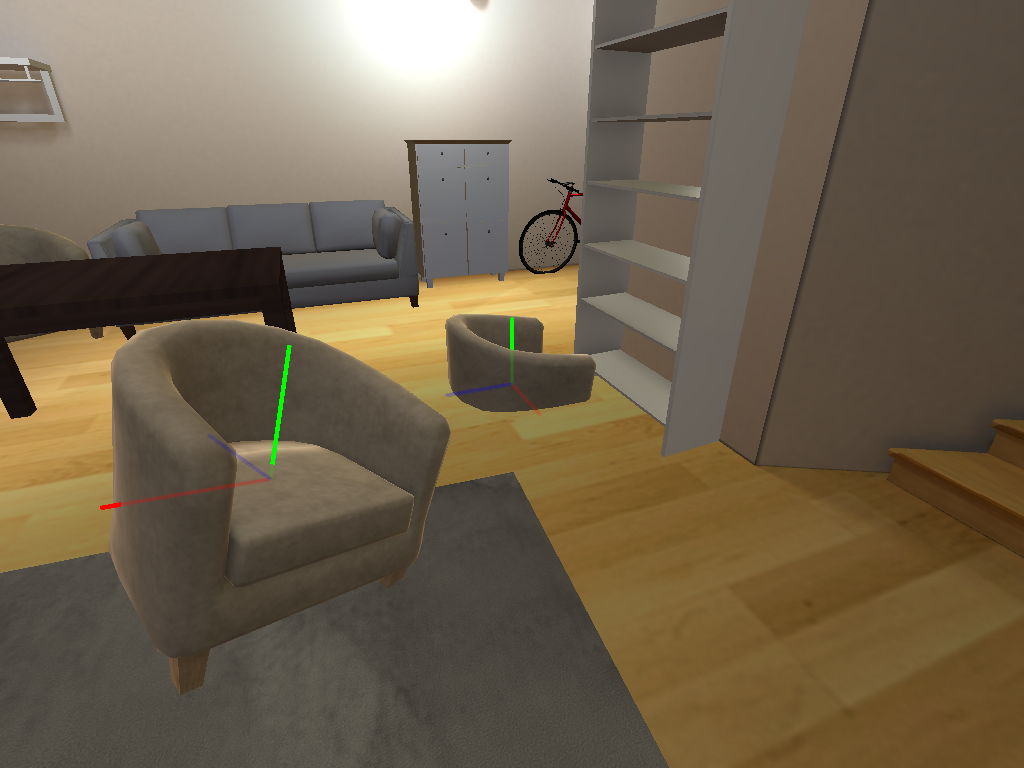

In [9]:
# [rigid_object_coord_frame]
rigid_obj_mgr = sim.get_rigid_object_manager()
obj_template = os.path.join(
    data_path, "replica_cad/configs/objects/frl_apartment_chair_01.object_config.json"
)

# add two chair objects to the scene
obj0 = rigid_obj_mgr.add_object_by_template_handle(obj_template)
obj1 = rigid_obj_mgr.add_object_by_template_handle(obj_template)

# pose the first chair at the origin with identity rotation
obj0.translation = mn.Vector3(0.0, 0.0, 0.0)
obj0.rotation = mn.Quaternion()

# pose the second chair with an arbitrary translation and rotation
obj1.translation = mn.Vector3(1.1, 0.4, 1.2)
up_axis = mn.Vector3(0, 1, 0)
obj1.rotation = mn.Quaternion.rotation(mn.Deg(-60.0), up_axis) * mn.Quaternion.rotation(
    mn.Deg(20.0), mn.Vector3(0, 0, 1)
)

for obj in [obj0, obj1]:
    # use DebugLineRender's push_transform to draw axes in each object's local coordinate frame.
    lr.push_transform(obj.transformation)
    draw_axes(origin, axis_len=obj_axes_len)
    lr.pop_transform()

# save the camera transform for use in the next block
camera_transform = calc_camera_transform(eye_translation=eye_pos0, lookat=origin)
show_scene(camera_transform)
# [/rigid_object_coord_frame]

# Camera coordinate frame
Let's look more closely at the transform of the camera used for the previous image. The camera's local axes are similar to the chair: right = red = x+, up = green = y+, forward (into the scene) = z- (negation of blue z+ vector).

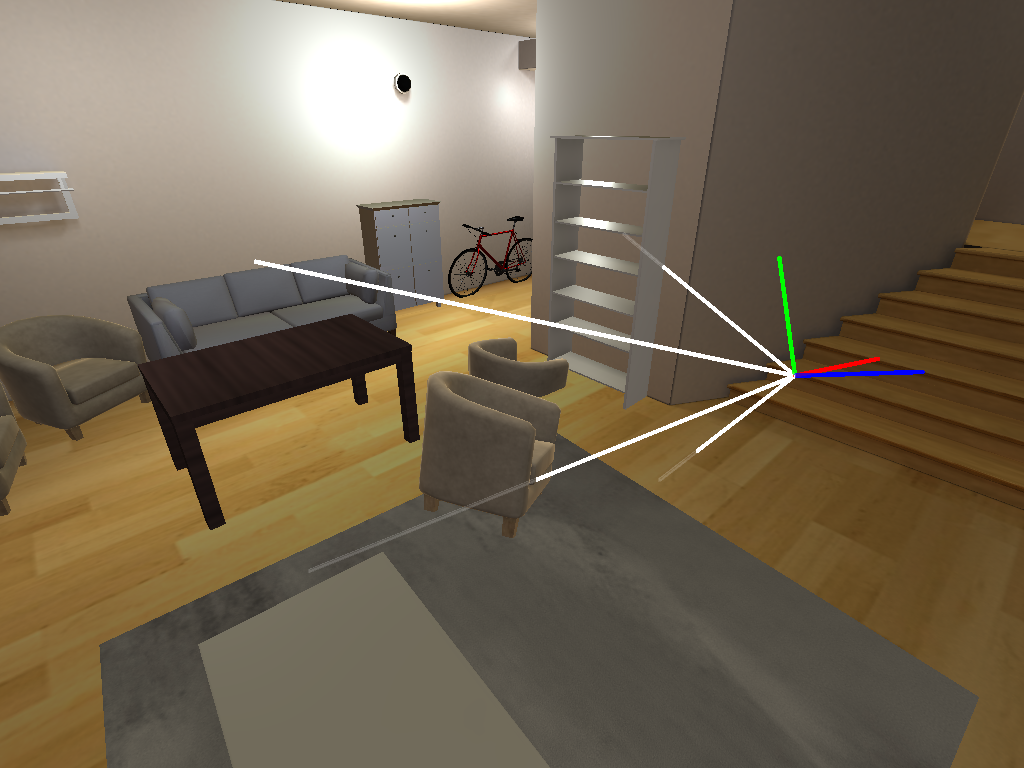

In [10]:
# [camera_coord_frame]
# draw the previous camera's local axes
lr.push_transform(camera_transform)
draw_axes(origin, axis_len=obj_axes_len)
# draw some approximate edges of the previous camera's frustum
fx = 2
fy = 1.5
fz = 4
lr.draw_transformed_line(origin, mn.Vector3(-fx, -fy, -fz), white)
lr.draw_transformed_line(origin, mn.Vector3(fx, -fy, -fz), white)
lr.draw_transformed_line(origin, mn.Vector3(-fx, fy, -fz), white)
lr.draw_transformed_line(origin, mn.Vector3(fx, fy, -fz), white)
lr.pop_transform()

# Show the scene from a position slightly offset from the previous camera.
eye_offset = mn.Vector3(0.5, 0.75, 1.75)
show_scene(calc_camera_transform(eye_translation=eye_pos0 + eye_offset, lookat=origin))
# [/camera_coord_frame]

# More object coordinate frames
Let's show the local origins and axes of all rigid objects in the scene.

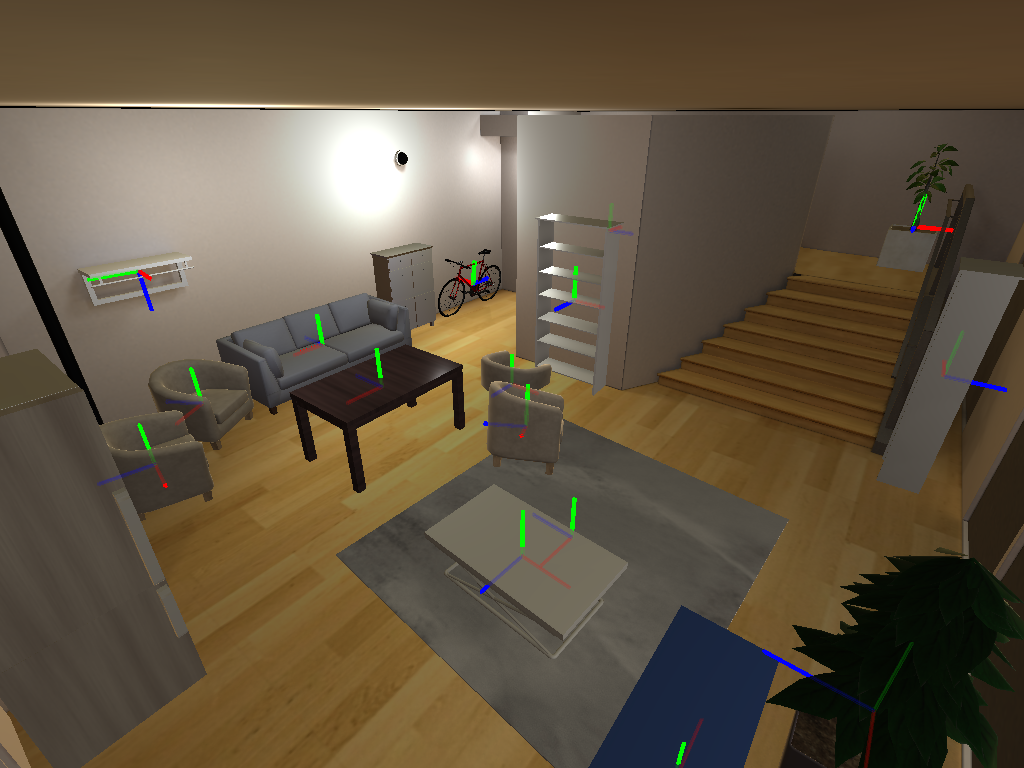

In [11]:
# [more_objects_coord_frame]
obj_dict = rigid_obj_mgr.get_objects_by_handle_substring()
for _, obj in obj_dict.items():
    lr.push_transform(obj.transformation)
    draw_axes(origin, axis_len=obj_axes_len)
    lr.pop_transform()

show_scene(calc_camera_transform(eye_translation=eye_pos1, lookat=origin))
# [/more_objects_coord_frame]

# Beware loading a GLB as a scene!
Let's re-create the sim and load a chair GLB as a scene. Beware, this is an example of what *not* to do! This is a legacy codepath to support loading GLB scenes from the MP3D dataset (not shown here). One quirk of this legacy codepath is that it rotates the model 90 degrees!

[13:36:20:855874]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_00.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[13:36:20:855942]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_01.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[13:36:20:855992]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_02.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/replica_cad`
[13:36:20:856042]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_03.navmesh` not found on disk as absolute path or relative to `/home/junting/repo/ha

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 525.147.05
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


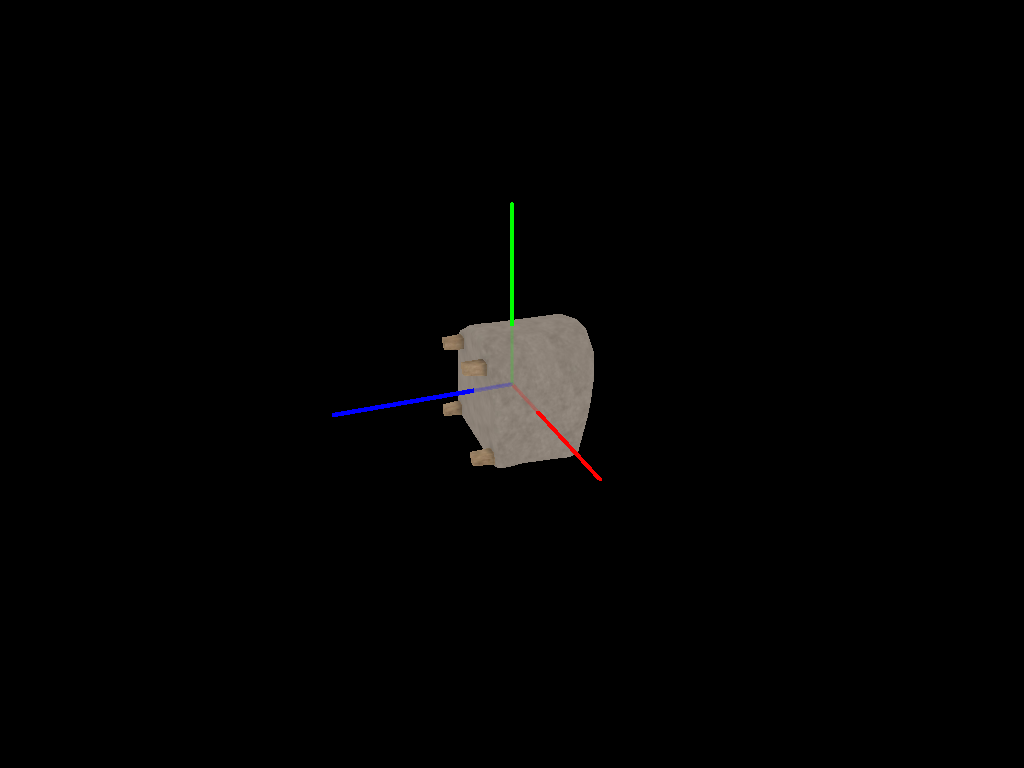

In [12]:
# [glb_scene_coord_frame]
create_sim_helper(
    scene_id=os.path.join(data_path, "replica_cad/objects/frl_apartment_chair_01.glb")
)
draw_axes(origin)
show_scene(calc_camera_transform(eye_translation=eye_pos0, lookat=origin))
# [/glb_scene_coord_frame]

# Blender conventions and sources of confusion
Blender is an open-source 3D-modeling tool that we on the Habitat team often use. We describe two caveats here:
1. Its convention is z-up, e.g. the default 3D camera is oriented such that z is up.
2. Blender automatically rotates gltf/glb models on import (essentially making the assumption that they were authored as y-up). It also reverses this rotation on export (see `+Y Up` gltf exporter option; enabled by default). The rotation is 90 degrees about the local x axis.

Here, we've imported `frl_apartment_chair_01.glb` and taken a screenshot. Note the axes with the same colors used elsewhere in this tutorial: red = x+, green = y+, and blue = z+. Compare this image to the section above, `A rigid object's local coordinate frame`. The local axes are different, but the chair still appears upright.

![Blender Chair](https://user-images.githubusercontent.com/6557808/134411206-eeff1529-04ab-4f20-bc7c-68102f2879f1.png)

Let's consider an individual vertex stored in a mesh in a gltf file. Suppose the vertex's local `(x,y,z)` position is `(1,2,3)`. After importing into blender, the vertex's local position in Blender will be `(1,-3,2)`. If the mesh is re-exported as a gltf, the vertex will be written to the file as `(1,2,3)`.